In [9]:
from helpers import math_helper
from sensors.activpal import *
from utils import read_functions
from scipy import signal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import statistics
import os

import matplotlib.pyplot as plt

Adnan Akbas
# Feature Extraction

In [10]:
activpal = Activpal()
features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'activiteit']
activity_columns = ['activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen', 'activity_sitten']
activities = ['lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']

In [11]:
def extract_features_from_correspondent(correspondent, segment_size=6.4):
    features_df = pd.DataFrame(columns=features_columns, index=pd.to_datetime([]))

    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)

    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        if not activity.empty:
            start_time = activity.start
            stop_time = activity.stop
            activpal_df = activpal.read_data(correspondent, start_time, stop_time)

            # denormalizing dataset
            activpal_df['x'] = math_helper.convert_value_to_g(activpal_df['pal_accX'])
            activpal_df['y'] = math_helper.convert_value_to_g(activpal_df['pal_accY'])
            activpal_df['z'] = math_helper.convert_value_to_g(activpal_df['pal_accZ'])

            date_range = pd.date_range(start_time, stop_time, freq=str(segment_size) + 'S')
            
            for time in date_range:
                segment_time = time + pd.DateOffset(seconds=segment_size)
                activpal_segment = activpal_df[(activpal_df.index >= time) & (activpal_df.index <= segment_time)]

                stdev_x =  statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                mean_x = activpal_segment['x'].mean()

                stdev_y =  statistics.stdev(activpal_segment['y']) if len(activpal_segment['y']) >= 2 else 0
                mean_y = activpal_segment['y'].mean()

                stdev_z =  statistics.stdev(activpal_segment['z']) if len(activpal_segment['z']) >= 2 else 0
                mean_z = activpal_segment['z'].mean()  


                features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, activity_name]

    return features_df

def extract_features_from_all_correspondents(segment_size=6.4):
    all_features_df = pd.DataFrame(index=pd.to_datetime([]))

    print("Starting extracting features for segment_size ", segment_size)

    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            for respDirect in directory[1]:
                if respDirect not in ['output', 'throughput', 'Test data','.ipynb_checkpoints', 'BMR035', 'BMR100', 'BMR051', 'BMR027']:
                  #  if respDirect not in test_users:
                    #print("Extracting " + respDirect)
                    features_df = extract_features_from_correspondent(respDirect, segment_size)
                    all_features_df = pd.concat([all_features_df, features_df])

    print("Done extracting features for segment_size ", segment_size)

    return all_features_df

In [14]:
def get_model_scores_on_segment_size(segment_size):
    features_dataset = extract_features_from_all_correspondents(segment_size)

    features_dataset[activity_columns] = 0

    features_dataset.loc[(features_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
    features_dataset.loc[(features_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
    features_dataset.loc[(features_dataset['activiteit'] == 'springen'), 'activity_jumping'] = 1
    features_dataset.loc[(features_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
    features_dataset.loc[(features_dataset['activiteit'] == 'traplopen'), 'activity_traplopen'] = 1
    features_dataset.loc[(features_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1

    features_dataset.drop('activiteit', axis=1, inplace=True)
    features_dataset.dropna(how='any', inplace=True)

    # training dataset
    x = features_dataset[features_columns[:-1]]
    y = features_dataset[activity_columns]

    train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=23, stratify=y)

    # validation dataset
    ftc = RandomForestClassifier(n_estimators=179, random_state=0)
    ftc.fit(train_x, train_y)

    prediction_y = ftc.predict(valid_x)

    accuracy = accuracy_score(valid_y, prediction_y, normalize=True)
    precision = precision_score(valid_y, prediction_y, average='micro')
    recall = recall_score(valid_y, prediction_y, average='micro')

    #cross validation
    ftc = RandomForestClassifier(n_estimators=179, random_state=0)

    cross_val_accuracy_scores = cross_val_score(ftc, x, y, scoring='accuracy')
    cross_val_precision_scores = cross_val_score(ftc, x, y , scoring='precision_micro')
    cross_val_recall_scores = cross_val_score(ftc, x, y , scoring='recall_micro')

    return [accuracy , precision, recall, cross_val_accuracy_scores.mean(), cross_val_precision_scores.mean(), cross_val_recall_scores.mean()]


In [ ]:
score_columns = ['accuracy', 'precision', 'recall', 'cross_val_accuracy',  'cross_val_precision',  'cross_val_recall']
results = pd.DataFrame(columns=score_columns)
segment_sizes = [0.4, 0.8, 1.0, 1.6, 2.0, 3.2, 4.0, 6.4, 8.0, 10.0, 12.8]

for segment_size in segment_sizes:
    results.loc[segment_size] = get_model_scores_on_segment_size(segment_size)

In [ ]:
results

In [15]:
def plot_stuff(df):
    df.plot(y=['accuracy', 'precision', 'recall'], marker='o', ylabel='scores', xlabel='segment size(seconds)', title= 'validation dataset')
    df.plot(y=['cross_val_accuracy', 'cross_val_precision', 'cross_val_recall'], marker='o',  ylabel='scores',xlabel='segment size(seconds)', title = 'cross validation')

In [ ]:
plot_stuff(results)

In [16]:
score_columns = ['accuracy', 'precision', 'recall', 'cross_val_accuracy',  'cross_val_precision',  'cross_val_recall']
results = pd.DataFrame(columns=score_columns)
segment_sizes = np.arange(8.0, 13, 0.1)

for segment_size in segment_sizes:
    results.loc[segment_size] = get_model_scores_on_segment_size(round(segment_size, 1))

Starting extracting features for segment_size  8.0
Done extracting features for segment_size  8.0
Starting extracting features for segment_size  8.1
Done extracting features for segment_size  8.1
Starting extracting features for segment_size  8.2
Done extracting features for segment_size  8.2
Starting extracting features for segment_size  8.3
Done extracting features for segment_size  8.3
Starting extracting features for segment_size  8.4
Done extracting features for segment_size  8.4
Starting extracting features for segment_size  8.5
Done extracting features for segment_size  8.5
Starting extracting features for segment_size  8.6
Done extracting features for segment_size  8.6
Starting extracting features for segment_size  8.7
Done extracting features for segment_size  8.7
Starting extracting features for segment_size  8.8
Done extracting features for segment_size  8.8
Starting extracting features for segment_size  8.9
Done extracting features for segment_size  8.9
Starting extracting 

In [17]:
results.head()

,accuracy,precision,recall,cross_val_accuracy,cross_val_precision,cross_val_recall
8.0,0.921026,0.943277,0.921026,0.833546,0.882947,0.833546
8.1,0.920782,0.945090,0.920782,0.826068,0.885384,0.826068
8.2,0.928496,0.949462,0.928496,0.829306,0.888867,0.829306
8.3,0.934461,0.954644,0.934461,0.828964,0.877221,0.828964
8.4,0.930886,0.946213,0.930886,0.829016,0.877584,0.829016


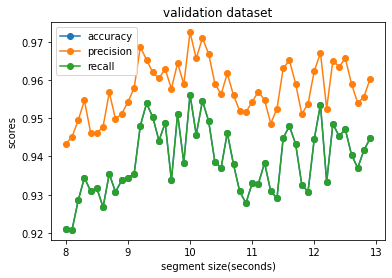

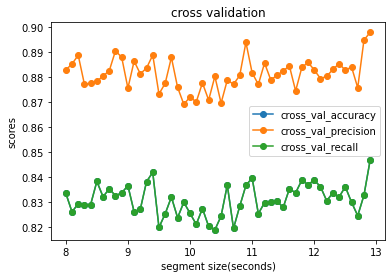

In [18]:
plot_stuff(results)

In [21]:
score_columns = ['accuracy', 'precision', 'recall', 'cross_val_accuracy',  'cross_val_precision',  'cross_val_recall']
results = pd.DataFrame(columns=score_columns)
segment_sizes = np.arange(12.8, 14.1, 0.2)

for segment_size in segment_sizes:
    results.loc[segment_size] = get_model_scores_on_segment_size(round(segment_size, 1))

Starting extracting features for segment_size  12.8
Done extracting features for segment_size  12.8
Starting extracting features for segment_size  13.0
Done extracting features for segment_size  13.0
Starting extracting features for segment_size  13.2
Done extracting features for segment_size  13.2
Starting extracting features for segment_size  13.4
Done extracting features for segment_size  13.4
Starting extracting features for segment_size  13.6
Done extracting features for segment_size  13.6
Starting extracting features for segment_size  13.8
Done extracting features for segment_size  13.8
Starting extracting features for segment_size  14.0
Done extracting features for segment_size  14.0


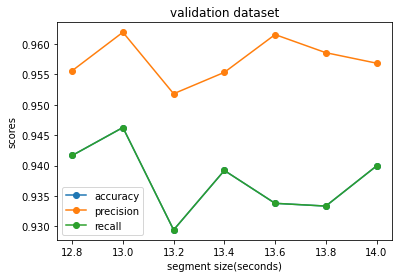

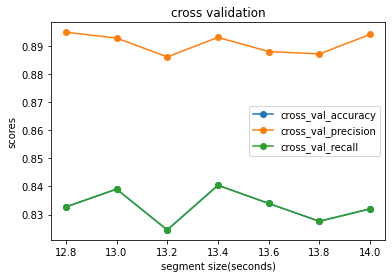

In [22]:
plot_stuff(results)

#### 